# WhatsApp Chat Analysis

In [1]:
import pandas as pd
import numpy as np

import re
from collections import Counter
import math
import time
import calendar
from datetime import timedelta

# !pip install emoji
import emoji

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.subplots as sp

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import spacy
from spacy.lang.tr.stop_words import STOP_WORDS
# !python -m spacy download en_core_web_sm
# !import spacyturk # https://github.com/spacyturk/spacyturk
# spacyturk.download("tr_floret_web_lg") # downloads the spaCyTurk model


## Load Data

The following code loads and converts data to a DataFrame. The function takes a file path as input, reads the file line by line, extracts data using a regular expression pattern that captures three groups of characters from each line (timestamp, sender, and message). If a line does not match the pattern, it is appended to the message of the previous line. The extracted data is stored in a list of tuples, where each tuple contains the timestamp, sender, and message. The function returns a pandas DataFrame created from the list of tuples.

In [2]:
def extract_data_from_file_path_all_lines(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for i, line in enumerate(file):
            line = line.replace("\u200e", "")
            pattern = r'\[(.*?)\]\s([^:]+):\s(.+)'
            # pattern = r'\[(.*?)\]\s(.+):\s(.+)'
            # pattern = r'\[(.*?)\]\s([\w\s]+):\s(.+)'
            # pattern = r'\[(.*?[0-9]{1}.*?[0-9]{2}.*?)\]\s([\w\s]+):\s(.+)'
            match = re.search(pattern, line)
            if match:
                if i != 0:
                    data.append([timestamp, sender, message])
                timestamp = match.group(1)
                sender = match.group(2)
                message = match.group(3)
            else:
                message += ' ' + line
        if message:
            data.append([timestamp, sender, message])
            
    # Create a DataFrame from the list of tuples
    df = pd.DataFrame(data, columns=['datetime_str', 'sender', 'text'])
    
    return df

In [3]:
def extract_data_from_streamlit_input_all_lines(uploaded_file):
    data = []
    for i, line in enumerate(uploaded_file):
        pattern = r'\[(.*?)\]\s([^:]+):\s(.+)'
        # pattern = r'\[(.*?)\]\s(.+):\s(.+)'
        # pattern = r'\[(.*?)\]\s([\w\s]+):\s(.+)'
        # pattern = r'\[(.*?[0-9]{1}.*?[0-9]{2}.*?)\]\s([\w\s]+):\s(.+)'
        line = line.decode('utf-8')
        match = re.search(pattern, line)
        if match:
            if i != 0:
                data.append([timestamp, sender, message])
            timestamp = match.group(1)
            sender = match.group(2)
            message = match.group(3).replace("\u200e", "")
        else:
            message += ' ' + line
    if message:
        data.append([timestamp, sender, message])
            
    # Create a DataFrame from the list of tuples
    df = pd.DataFrame(data, columns=['datetime_str', 'sender', 'text'])
    
    return df

In [4]:
df = extract_data_from_file_path_all_lines('sample_chat.txt')
df.head()

datetime_str  sender                                               text
0  3/25/23, 6:15 PM    Mark  I heard that the weather might be a bit chilly...
1  3/25/23, 6:20 PM  Rachel  Yeah, I think Mark is right. Maybe we should d...
2  3/25/23, 6:25 PM   David  How about we go to an escape room? I've never ...
3  3/25/23, 6:50 PM   Sarah  That works for me. What time should we meet th...
4  3/25/23, 6:55 PM    John  Sounds good to me! Can't wait to try it out. (...

## Extract and remove media, url, emoji from text

In this section, we describe three functions that are used to count the number of images, audios, videos, urls, and emojis shared.

The clean_omitted_text function replaces certain strings in the 'text' column of the DataFrame with an empty string and creates new columns to indicate whether the corresponding row represents an image, audio, video, or sticker.

The extract_replace_urls function extracts all URLs in the 'text' column of the DataFrame and stores them in a new column 'urls'. It then replaces all URLs in the 'text' column with the string 'url' and counts the number of URLs in each row.

The extract_and_replace_emojis function extracts all emojis from the 'text' column of the DataFrame and stores them in a new column 'emojis'. It then replaces all emojis in the 'text' column with the string ' emoji ' and counts the number of emojis in each row.

In [5]:
def clean_omitted_text(df):
    # Create a new columns
    df['is_image'] = (df['text'] == 'image omitted')*1
    df['is_audio'] = (df['text'] == 'audio omitted')*1
    df['is_video'] = (df['text'] == 'video omitted')*1
    df['is_sticker'] = (df['text'] == 'sticker omitted')*1

    # Replace the strings 'image omitted', 'audio omitted', or 'video omitted' with an empty string
    df['text'] = df['text'].str.replace('image omitted', '')
    df['text'] = df['text'].str.replace('audio omitted', '')
    df['text'] = df['text'].str.replace('video omitted', '')
    df['text'] = df['text'].str.replace('sticker omitted', '')
    
    return df

In [6]:
def extract_replace_urls(df):
    # Define a regular expression pattern to match URLs
    url_pattern = re.compile(r'https?://\S+')

    # Extract all URLs in the 'text' column and store them in a new column 'urls'
    df['urls'] = df['text'].str.findall(url_pattern)

    # Replace all URLs in the 'text' column with the string 'url'
    df['text'] = df['text'].str.replace(url_pattern, '')

    # Count the number of URLs in each row and store them in a new column 'n_urls'
    df['n_urls'] = df['urls'].apply(lambda x: len(x) if isinstance(x, list) else 0)

    return df

In [7]:
def extract_and_replace_emojis(df):
    # Define a function to extract emojis from a string
    def extract_emojis(text):
        return [char for char in text if emoji.is_emoji(char)]

    # Define a function to replace emojis in a string with ' emoji '
    def replace_emojis(text):
        for char in text:
            if emoji.is_emoji(char):
                text = text.replace(char, '')
        return text

    # Apply the extract_emojis function to the 'text' column and store the result in a new column 'emojis'
    df['emojis'] = df['text'].apply(extract_emojis)

    # Apply the replace_emojis function to the 'text' column to replace emojis with ' emoji '
    df['text'] = df['text'].apply(replace_emojis)
    
    # Count the number of emojis
    df['n_emojis'] = df['emojis'].apply(lambda x: len(x) if isinstance(x, list) else 0)

    return df

In [8]:
df = extract_data_from_file_path_all_lines('sample_chat.txt')
df = clean_omitted_text(df)
df = extract_replace_urls(df)
df = extract_and_replace_emojis(df)
df.head()

datetime_str  sender  \
0  3/25/23, 6:15 PM    Mark   
1  3/25/23, 6:20 PM  Rachel   
2  3/25/23, 6:25 PM   David   
3  3/25/23, 6:50 PM   Sarah   
4  3/25/23, 6:55 PM    John   

                                                text  is_image  is_audio  \
0  I heard that the weather might be a bit chilly...         0         0   
1  Yeah, I think Mark is right. Maybe we should d...         0         0   
2  How about we go to an escape room? I've never ...         0         0   
3  That works for me. What time should we meet th...         0         0   
4    Sounds good to me! Can't wait to try it out. ()         0         0   

   is_video  is_sticker urls  n_urls emojis  n_emojis  
0         0           0   []       0     []         0  
1         0           0   []       0     []         0  
2         0           0   []       0     []         0  
3         0           0   []       0     []         0  
4         0           0   []       0     []         0

## Create Feauteres

In this section, we define two functions that are used to add new columns to a pandas DataFrame containing WhatsApp message data. These new columns provide additional information about the dates and times of each message, which can be used for time-based analysis.

The first function, add_datetime_column, combines the existing 'date' and 'time' columns into a single 'datetime' column using the pandas to_datetime method. This makes it easier to perform time-based analysis on the data and extract insights related to messaging behavior over time.

The second function, add_date_columns, uses the 'datetime' column created by the add_datetime_column function to add new columns for the year, month, day, day of week, and hour of each message. It also adds a 'date' column containing only the date portion of the 'datetime' column. These columns can be used to analyze message frequency by hour or day of week, or to identify patterns in messaging behavior over time.

By using these functions to add additional date and time columns to the DataFrame, we can gain a more comprehensive understanding of the messaging behavior of the WhatsApp group and uncover insights that may not have been visible before.

In [9]:
def add_datetime_column(df):
    # combine the date and time columns into a single datetime column
    df['datetime'] = pd.to_datetime(df['datetime_str'])

    return df

In [10]:
def add_date_columns(df):
    # add columns for the year, month, day, day of week, and hour of each message
    df['year'] = pd.to_datetime(df['datetime']).dt.year
    df['month'] = pd.to_datetime(df['datetime']).dt.month
    df['day'] = pd.to_datetime(df['datetime']).dt.day
    df['day_of_week'] = pd.to_datetime(df['datetime']).dt.dayofweek
    df['hour'] = pd.to_datetime(df['datetime']).dt.hour
    df['date'] = df['datetime'].dt.date

    return df

In [11]:
df = extract_data_from_file_path_all_lines('sample_chat.txt')
df = clean_omitted_text(df)
df = extract_replace_urls(df)
df = extract_and_replace_emojis(df)
df = add_datetime_column(df)
df = add_date_columns(df)
df.head()

datetime_str  sender  \
0  3/25/23, 6:15 PM    Mark   
1  3/25/23, 6:20 PM  Rachel   
2  3/25/23, 6:25 PM   David   
3  3/25/23, 6:50 PM   Sarah   
4  3/25/23, 6:55 PM    John   

                                                text  is_image  is_audio  \
0  I heard that the weather might be a bit chilly...         0         0   
1  Yeah, I think Mark is right. Maybe we should d...         0         0   
2  How about we go to an escape room? I've never ...         0         0   
3  That works for me. What time should we meet th...         0         0   
4    Sounds good to me! Can't wait to try it out. ()         0         0   

   is_video  is_sticker urls  n_urls emojis  n_emojis            datetime  \
0         0           0   []       0     []         0 2023-03-25 18:15:00   
1         0           0   []       0     []         0 2023-03-25 18:20:00   
2         0           0   []       0     []         0 2023-03-25 18:25:00   
3         0           0   []       0     []         0 2023-03-25 18:50:00   
4         0           0   []       0     []         0 2023-03-25 18:55:00   

   year  month  day  day_of_week  hour        date  
0  2023      3   25            5    18  2023-03-25  
1  2023      3   25            5    18  2023-03-25  
2  2023      3   25            5    18  2023-03-25  
3  2023      3   25            5    18  2023-03-25  
4  2023      3   25            5    18  2023-03-25

## Data Filter Option

This code filters a pandas DataFrame based on specified date ranges. It selects data from the last 12 months, current year, and previous year from the DataFrame based on a specified date column. The function returns three filtered DataFrames. This function is useful for performing time-based analysis on WhatsApp message data for specific time periods.

In [12]:
def select_date_ranges(df):
    """
    Selects data from the last 12 months, current year, and previous year from the given DataFrame based on the
    specified date column.
    """
    # Find the latest date in the datetime column of the DataFrame
    latest_date = df['datetime'].max().date()

    # Find the start date of the 12-month period
    start_date = (latest_date - timedelta(days=365)).strftime('%Y-%m-%d')

    # Filter the DataFrame to include only the last 12 months of data
    df_last_12_months = df[df['datetime'] >= start_date]

    # Find the year of the latest date
    current_year = latest_date.year

    # Filter the DataFrame to include only the rows from the current year
    df_current_year = df[df['datetime'].dt.year == current_year]

    # Find the year of the previous year
    previous_year = current_year - 1

    # Filter the DataFrame to include only the rows from the previous year
    df_previous_year = df[df['datetime'].dt.year == previous_year]
    
    return df_last_12_months, df_current_year, df_previous_year

In [13]:
df = extract_data_from_file_path_all_lines('sample_chat.txt')
df = clean_omitted_text(df)
df = extract_replace_urls(df)
df = extract_and_replace_emojis(df)
df = add_datetime_column(df)
df = add_date_columns(df)
df_last_12_months, df_current_year, df_previous_year = select_date_ranges(df)
df_current_year.head()

datetime_str  sender  \
0  3/25/23, 6:15 PM    Mark   
1  3/25/23, 6:20 PM  Rachel   
2  3/25/23, 6:25 PM   David   
3  3/25/23, 6:50 PM   Sarah   
4  3/25/23, 6:55 PM    John   

                                                text  is_image  is_audio  \
0  I heard that the weather might be a bit chilly...         0         0   
1  Yeah, I think Mark is right. Maybe we should d...         0         0   
2  How about we go to an escape room? I've never ...         0         0   
3  That works for me. What time should we meet th...         0         0   
4    Sounds good to me! Can't wait to try it out. ()         0         0   

   is_video  is_sticker urls  n_urls emojis  n_emojis            datetime  \
0         0           0   []       0     []         0 2023-03-25 18:15:00   
1         0           0   []       0     []         0 2023-03-25 18:20:00   
2         0           0   []       0     []         0 2023-03-25 18:25:00   
3         0           0   []       0     []         0 2023-03-25 18:50:00   
4         0           0   []       0     []         0 2023-03-25 18:55:00   

   year  month  day  day_of_week  hour        date  
0  2023      3   25            5    18  2023-03-25  
1  2023      3   25            5    18  2023-03-25  
2  2023      3   25            5    18  2023-03-25  
3  2023      3   25            5    18  2023-03-25  
4  2023      3   25            5    18  2023-03-25

## Clean Data and Create More Features

In this section, I define several functions that are used to preprocess text data. The preprocessing functions remove punctuation, stop words, digits, and spaces from the text, and optionally lemmatize the remaining words using a specified NLP model. Additionally, the clean_and_count_words function counts the number of words in each message and adds a new column to the DataFrame with the cleaned and preprocessed text.

In [14]:
nlp_en = spacy.load('en_core_web_sm')
nlp_tr = spacy.load('tr_floret_web_lg')

In [15]:
def clean_punct_stop_space(text, nlp):
    doc = nlp(text) 
    # Use a list comprehension to filter out punctuation, stop words, and spaces
    words = [token.text.lower() for token in doc
             if not token.is_punct 
             and not token.is_stop 
             and not token.is_digit 
             and not token.like_num
             and not token.text.isspace()]
    return words

In [16]:
def clean_punct_stop_space_lemma(text, nlp):
    doc = nlp(text) 
    # Use a list comprehension to filter out punctuation, stop words, and spaces,
    # and lemmatize the remaining words.
    words = [token.lemma_.lower() for token in doc 
             if not token.is_punct 
             and not token.is_stop 
             and not token.is_digit
             and not token.like_num
             and not token.text.isspace()]
    return words

In [17]:
def clean_and_count_words(df, clean_fn, nlp):
    # Apply the specified clean function to the specified text column of the df DataFrame
    df['clean_words'] = df['text'].apply(lambda x: clean_fn(x, nlp))

    # Length of the words in a message
    df['num_words'] = df['clean_words'].apply(lambda x: len(x))
    
    return df

In [18]:
df = extract_data_from_file_path_all_lines('sample_chat.txt')
df = clean_omitted_text(df)
df = extract_replace_urls(df)
df = extract_and_replace_emojis(df)
df = add_datetime_column(df)
df = add_date_columns(df)
df = clean_and_count_words(df, clean_punct_stop_space, nlp_tr)
df.head()

datetime_str  sender  \
0  3/25/23, 6:15 PM    Mark   
1  3/25/23, 6:20 PM  Rachel   
2  3/25/23, 6:25 PM   David   
3  3/25/23, 6:50 PM   Sarah   
4  3/25/23, 6:55 PM    John   

                                                text  is_image  is_audio  \
0  I heard that the weather might be a bit chilly...         0         0   
1  Yeah, I think Mark is right. Maybe we should d...         0         0   
2  How about we go to an escape room? I've never ...         0         0   
3  That works for me. What time should we meet th...         0         0   
4    Sounds good to me! Can't wait to try it out. ()         0         0   

   is_video  is_sticker urls  n_urls emojis  n_emojis            datetime  \
0         0           0   []       0     []         0 2023-03-25 18:15:00   
1         0           0   []       0     []         0 2023-03-25 18:20:00   
2         0           0   []       0     []         0 2023-03-25 18:25:00   
3         0           0   []       0     []         0 2023-03-25 18:50:00   
4         0           0   []       0     []         0 2023-03-25 18:55:00   

   year  month  day  day_of_week  hour        date  \
0  2023      3   25            5    18  2023-03-25   
1  2023      3   25            5    18  2023-03-25   
2  2023      3   25            5    18  2023-03-25   
3  2023      3   25            5    18  2023-03-25   
4  2023      3   25            5    18  2023-03-25   

                                         clean_words  num_words  
0  [i, heard, that, the, weather, might, be, a, b...         22  
1  [yeah, i, think, mark, is, right, maybe, we, s...         13  
2  [how, about, we, go, to, an, escape, room, i'v...         21  
3  [that, works, for, me, what, time, should, we,...         10  
4  [sounds, good, to, me, can't, wait, to, try, i...         10

## Plots

In [19]:
df = extract_data_from_file_path_all_lines('sample_chat.txt')
df = clean_omitted_text(df)
df = extract_replace_urls(df)
df = extract_and_replace_emojis(df)
df = add_datetime_column(df)
df = add_date_columns(df)
df = clean_and_count_words(df, clean_punct_stop_space, nlp_tr)

### Plot 1

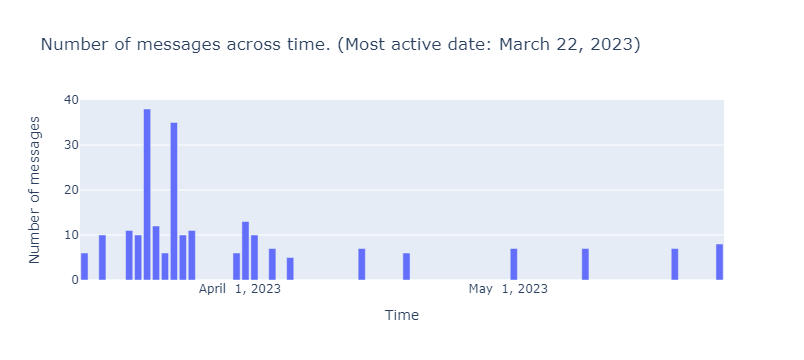

In [20]:
def plot_message_count_vs_time_bar(df):
    # group the DataFrame by datetime and count the number of rows in each group
    count_by_datetime = df.groupby(pd.Grouper(key='datetime', freq='D')).size().reset_index(name='count')
    
    # get the date with the highest count
    most_active_date_index = count_by_datetime['count'].idxmax()
    most_active_date = count_by_datetime.loc[most_active_date_index, 'datetime'].strftime('%B %e, %Y')

    # determine the duration of the data in days
    duration = (count_by_datetime['datetime'].max() - count_by_datetime['datetime'].min()).days

    # set the x-axis tick format based on the duration of the data
    if duration <= 90:
        tick_format = '%B %e, %Y'
        dtick = 'M1'
    elif duration <= 180:
        tick_format = '%B %Y'
        dtick = 'M2'
    elif duration <= 360:
        tick_format = '%B %Y'
        dtick = 'M3'
    elif duration <= 720:
        tick_format = '%B %Y'
        dtick = 'M6'
    else:
        tick_format = '%Y'
        dtick = 'M12'

    # plot the message counts vs time using Plotly
    fig = px.bar(count_by_datetime, x='datetime', y='count', 
                 title='Number of messages across time. (Most active date: {})'.format(most_active_date))

    # set the x-axis tick format and tick marks
    fig.update_layout(xaxis=dict(
        tickmode='linear',
        tick0=next((d for d in df['datetime'] if d.day == 1), None),
        dtick=dtick,
        tickformat=tick_format,
        tickangle=0),
        yaxis=dict(title='Number of messages'),
        xaxis_title='Time')

    return fig

fig = plot_message_count_vs_time_bar(df)
fig.show()

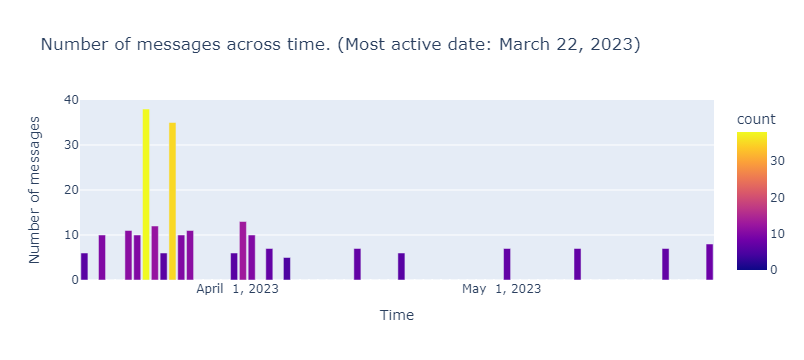

In [21]:
def plot_message_count_vs_time_bar(df):
    # group the DataFrame by datetime and count the number of rows in each group
    count_by_datetime = df.groupby(pd.Grouper(key='datetime', freq='D')).size().reset_index(name='count')
    
    # get the date with the highest count
    most_active_date_index = count_by_datetime['count'].idxmax()
    most_active_date = count_by_datetime.loc[most_active_date_index, 'datetime'].strftime('%B %e, %Y')

    # determine the duration of the data in days
    duration = (count_by_datetime['datetime'].max() - count_by_datetime['datetime'].min()).days

    # set the x-axis tick format based on the duration of the data
    if duration <= 90:
        tick_format = '%B %e, %Y'
        dtick = 'M1'
    elif duration <= 180:
        tick_format = '%B %Y'
        dtick = 'M2'
    elif duration <= 360:
        tick_format = '%B %Y'
        dtick = 'M3'
    elif duration <= 720:
        tick_format = '%B %Y'
        dtick = 'M6'
    else:
        tick_format = '%Y'
        dtick = 'M12'

    # plot the message counts vs time using Plotly
    fig = px.bar(count_by_datetime, x='datetime', y='count', 
                 title='Number of messages across time. (Most active date: {})'.format(most_active_date),
                 color='count', color_discrete_sequence=['lightblue']*(len(count_by_datetime)-1)+['navy'])

    # set the x-axis tick format and tick marks
    fig.update_layout(xaxis=dict(
        tickmode='linear',
        tick0=next((d for d in df['datetime'] if d.day == 1), None),
        dtick=dtick,
        tickformat=tick_format,
        tickangle=0),
        yaxis=dict(title='Number of messages'),
        xaxis_title='Time')

    return fig

fig = plot_message_count_vs_time_bar(df)
fig.show()

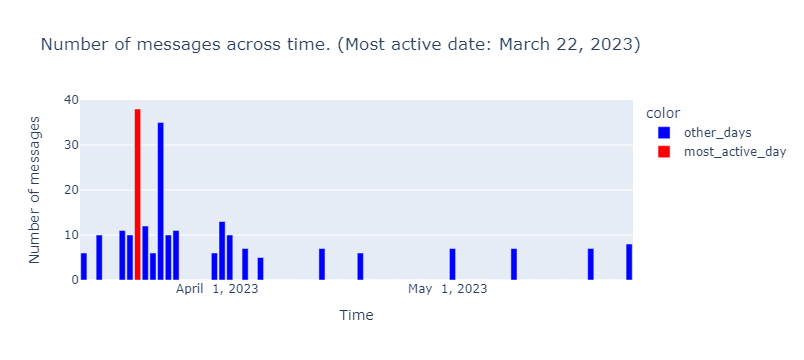

In [22]:
def plot_message_count_vs_time_bar(df):
    # group the DataFrame by datetime and count the number of rows in each group
    count_by_datetime = df.groupby(pd.Grouper(key='datetime', freq='D')).size().reset_index(name='count')
    
    # get the date with the highest count
    most_active_date_index = count_by_datetime['count'].idxmax()
    most_active_date = count_by_datetime.loc[most_active_date_index, 'datetime'].strftime('%B %e, %Y')

    # determine the duration of the data in days
    duration = (count_by_datetime['datetime'].max() - count_by_datetime['datetime'].min()).days

    # set the x-axis tick format based on the duration of the data
    if duration <= 90:
        tick_format = '%B %e, %Y'
        dtick = 'M1'
    elif duration <= 180:
        tick_format = '%B %Y'
        dtick = 'M2'
    elif duration <= 360:
        tick_format = '%B %Y'
        dtick = 'M3'
    elif duration <= 720:
        tick_format = '%B %Y'
        dtick = 'M6'
    else:
        tick_format = '%Y'
        dtick = 'M12'

    # plot the message counts vs time using Plotly
    fig = px.bar(count_by_datetime, x='datetime', y='count', 
                 title='Number of messages across time. (Most active date: {})'.format(most_active_date),
                 color=count_by_datetime['datetime'].apply(lambda x: 'most_active_day' 
                                                           if x.strftime('%B %e, %Y') == most_active_date else 'other_days'),
                 color_discrete_map={'most_active_day': 'red', 'other_days': 'blue'})

    # set the x-axis tick format and tick marks
    fig.update_layout(xaxis=dict(
        tickmode='linear',
        tick0=next((d for d in df['datetime'] if d.day == 1), None),
        dtick=dtick,
        tickformat=tick_format,
        tickangle=0),
        yaxis=dict(title='Number of messages'),
        xaxis_title='Time')

    return fig

fig = plot_message_count_vs_time_bar(df)
fig.show()

### Plot 2

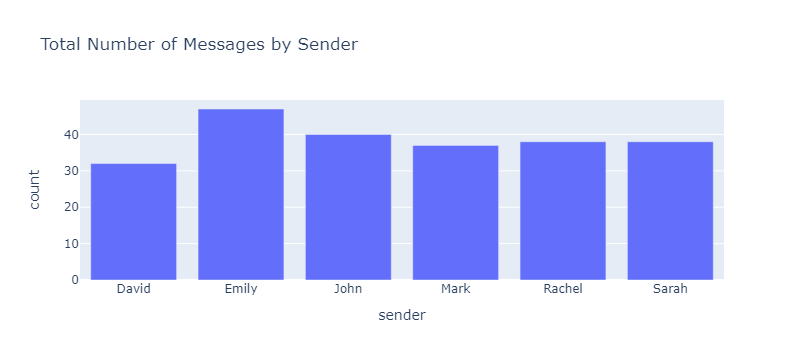

In [23]:
def plot_total_messages_by_sender(df):
    # group the DataFrame by sender and count the number of rows in each group
    count_by_sender = df.groupby('sender').size().reset_index(name='count')
    
    # plot the total number of messages per sender using Plotly
    fig = px.bar(count_by_sender, x='sender', y='count', title='Total Number of Messages by Sender')
    return fig

fig = plot_total_messages_by_sender(df)
fig.show()

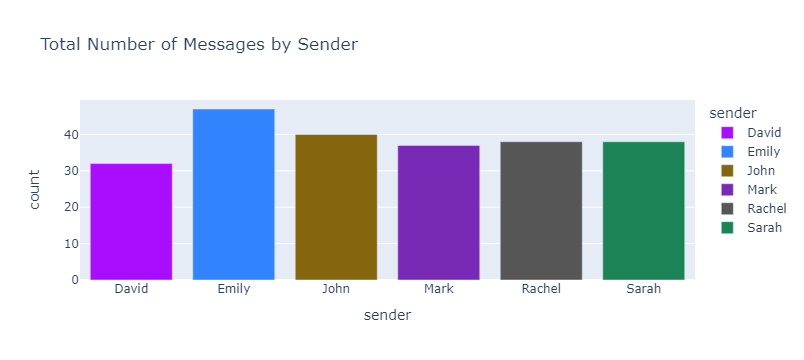

In [24]:
def plot_total_messages_by_sender(df):
    # group the DataFrame by sender and count the number of rows in each group
    count_by_sender = df.groupby('sender').size().reset_index(name='count')
    
    # plot the total number of messages per sender using Plotly
    fig = px.bar(count_by_sender, x='sender', y='count', color='sender',
                 title='Total Number of Messages by Sender', 
                 color_discrete_sequence=px.colors.qualitative.Alphabet)
    return fig

fig = plot_total_messages_by_sender(df)
fig.show()

### Plot 3

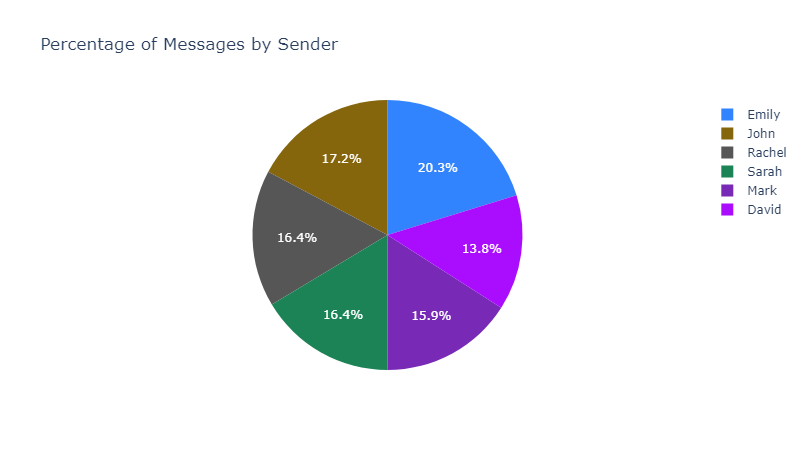

In [25]:
def plot_total_messages_by_sender_pie(df):
    # group the DataFrame by sender and count the number of rows in each group
    count_by_sender = df.groupby('sender').size().reset_index(name='count')
    
    # plot the total number of messages per sender using Plotly
    fig = px.pie(count_by_sender, values='count', names='sender', 
                 title='Percentage of Messages by Sender',
                 color='sender', color_discrete_sequence=px.colors.qualitative.Alphabet)

    # modify the layout of the plot to make it larger
    fig.update_layout(
        width=600,
        height=450
    )

    return fig

fig = plot_total_messages_by_sender_pie(df)
fig.show()

### Plot 4

In [26]:
def compute_cumulative_count(df):
    # create a copy of the original DataFrame with just the columns we need
    df_cumulative = df[['datetime', 'sender']].copy()

    # group by sender and date, and count the number of messages for each group
    df_cumulative = df_cumulative.groupby(['sender', pd.Grouper(key='datetime', freq='D')]).size().reset_index(name='count')

    # sort by datetime column
    df_cumulative = df_cumulative.sort_values(by='datetime')

    # compute the cumulative sum of messages for each sender and date
    df_cumulative['cumulative_count'] = df_cumulative.groupby(['sender'])['count'].cumsum()

    # pivot the data to create a wide format
    cumulative_count_df = df_cumulative.pivot(index='datetime', columns='sender', values='cumulative_count').fillna(method='ffill')

    # reset the index and create a new 'date' column
    cumulative_count_df = cumulative_count_df.reset_index().rename(columns={'datetime': 'date'})

    # melt the DataFrame to create a long format
    cumulative_count_df = cumulative_count_df.melt(id_vars=['date'], var_name='sender', value_name='cumulative_count')
    
    return cumulative_count_df

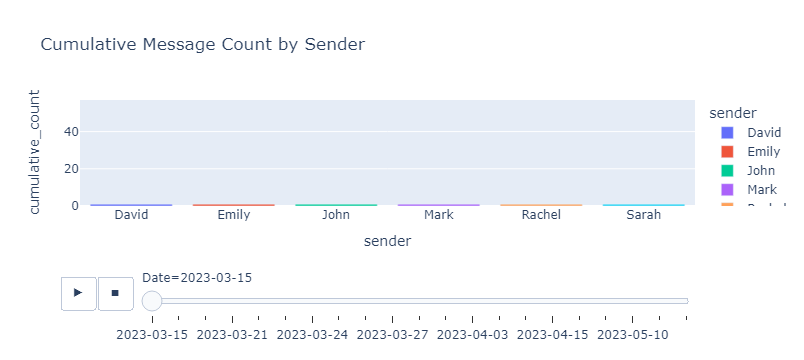

In [27]:
def create_cumulative_count_bar_chart(df):
    
    cumulative_count_df = compute_cumulative_count(df)
    cumulative_count_df['Date'] = cumulative_count_df['date'].dt.date
    cumulative_count_df['Month'] = cumulative_count_df['date'].dt.month

    # Compute the maximum value of cumulative_count across all senders
    max_cumulative_count = cumulative_count_df['cumulative_count'].max()

    # Set the range_y parameter to a tuple with the lower bound as 0 and the upper bound as the maximum value plus a buffer
    range_y = (0, max_cumulative_count + 10)

    # Create the bar chart with range_y set dynamically
    fig = px.bar(cumulative_count_df, x="sender", y="cumulative_count", color="sender",
      animation_frame="Date", range_y=range_y, title="Cumulative Message Count by Sender")
    
    fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 1
    fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 1
    
    return fig

fig = create_cumulative_count_bar_chart(df)
fig.show()

### Plot 5

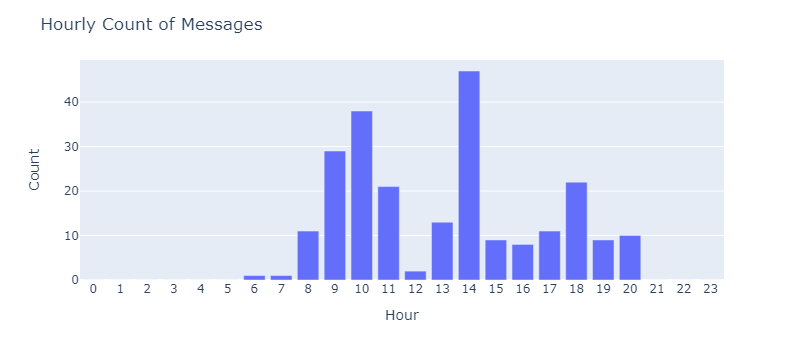

In [28]:
def plot_hourly_count_plotly(df):
    # Group messages by hour and count the number of messages for each hour
    hourly_count = df.groupby('hour').size().reset_index(name='count')

    # Create a new DataFrame that contains all hours, even if there are no messages sent at that hour
    all_hours = pd.DataFrame({'hour': range(24)})

    # Merge the hourly_count DataFrame with the all_hours DataFrame to fill in missing hours with a count of 0
    hourly_count = pd.merge(all_hours, hourly_count, on='hour', how='left').fillna(0)

    # Create a bar plot of the hourly count of messages
    fig = px.bar(hourly_count, x='hour', y='count')

    # Set the title of the plot
    fig.update_layout(title_text='Hourly Count of Messages')

    # Set the x-axis label to 'Hour' and the y-axis label to 'Count'
    fig.update_xaxes(title_text='Hour', tickmode='linear', dtick=1)
    fig.update_yaxes(title_text='Count')

    return fig

fig = plot_hourly_count_plotly(df)
fig.show()

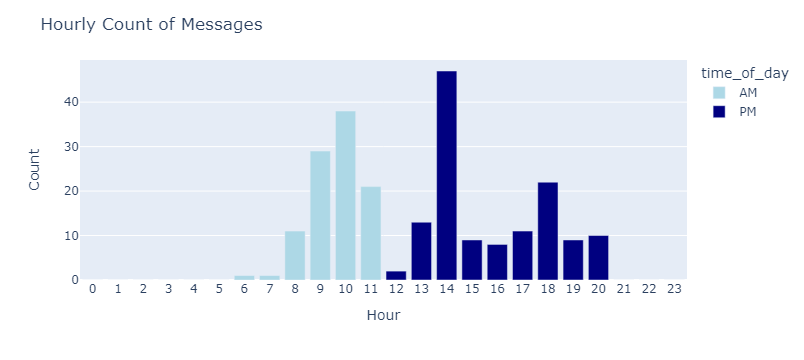

In [29]:
def plot_hourly_count_plotly(df):
    # Group messages by hour and count the number of messages for each hour
    hourly_count = df.groupby('hour').size().reset_index(name='count')

    # Create a new DataFrame that contains all hours, even if there are no messages sent at that hour
    all_hours = pd.DataFrame({'hour': range(24)})

    # Merge the hourly_count DataFrame with the all_hours DataFrame to fill in missing hours with a count of 0
    hourly_count = pd.merge(all_hours, hourly_count, on='hour', how='left').fillna(0)

    # Add a column to the DataFrame that indicates whether the hour is AM or PM
    hourly_count['time_of_day'] = ['AM' if hour < 12 else 'PM' for hour in hourly_count['hour']]

    # Create a bar plot of the hourly count of messages, with different colors for AM and PM
    fig = px.bar(hourly_count, x='hour', y='count', color='time_of_day',
                 color_discrete_map={'AM': 'lightblue', 'PM': 'navy'})

    # Set the title of the plot
    fig.update_layout(title_text='Hourly Count of Messages')

    # Set the x-axis label to 'Hour' and the y-axis label to 'Count'
    fig.update_xaxes(title_text='Hour', tickmode='linear', dtick=1,
                     tickvals=hourly_count['hour'], 
                     ticktext=[f'{hour} {time_of_day}' for hour, 
                               time_of_day in zip(hourly_count['hour'], hourly_count['time_of_day'])])
    fig.update_yaxes(title_text='Count')

    return fig

fig = plot_hourly_count_plotly(df)
fig.show()

### Plot 6

In [30]:
def combine_user_messages(df):
    user_messages_per_user = df.groupby('sender')['clean_words'].apply(lambda x: [word for words in x for word in words])
    
    user_messages_all = []
    for user in user_messages_per_user.index:
        user_messages_all += user_messages_per_user[user]
    
    return user_messages_per_user, user_messages_all

In [31]:
def get_word_counts(words_list):
    return Counter(words_list)

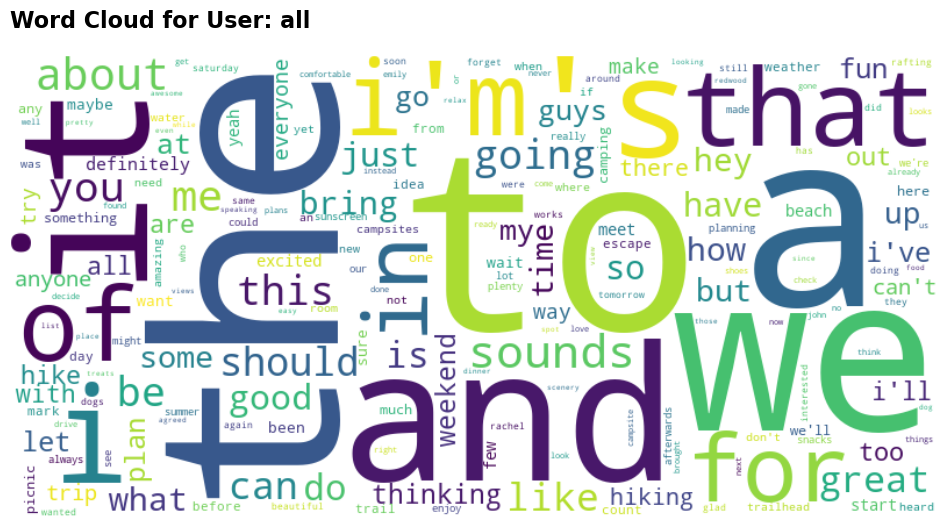

In [32]:
def create_wordcloud(df, user_name='all'):
    user_messages_per_user, user_messages_all = combine_user_messages(df)
    if user_name == 'all':
        data = get_word_counts(user_messages_all)
    else:
        data = get_word_counts(user_messages_per_user[user_name])

    words = data.keys()
    counts = data.values()

    wordcloud = WordCloud(width=800, 
                          height=400, 
                          background_color='white').generate_from_frequencies(dict(zip(words, counts)))

    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    
    # add a bold title to the plot with smaller font size and more space
    plt.title("Word Cloud for User: {}".format(user_name), fontdict={'fontsize': 16, 'fontweight': 'bold'}, pad=20, loc='left')
    
    return plt

plt = create_wordcloud(df)
plt.show()

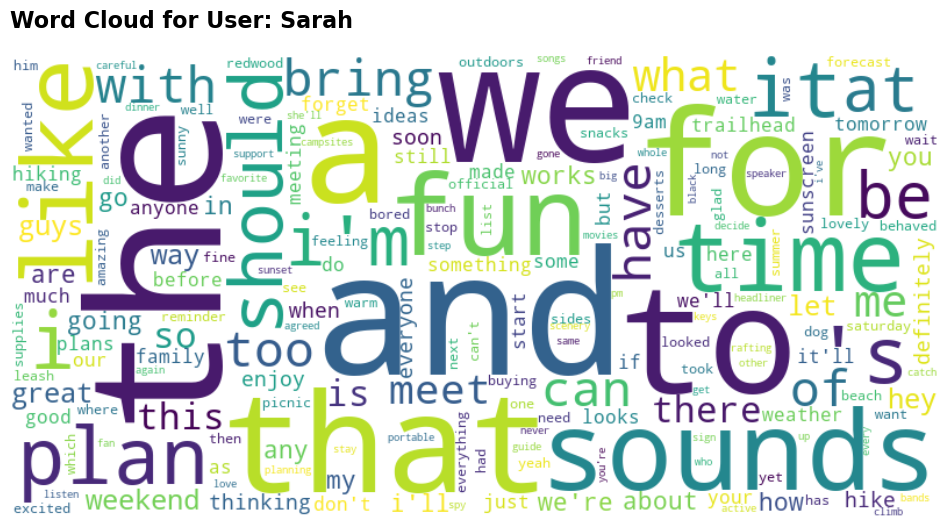

In [33]:
sender = df['sender'].iloc[-1]
plt = create_wordcloud(df, sender)
plt.show()

### Plot 7

In [34]:
def sort_word_counts(word_counts):
    sorted_counts = sorted(word_counts.items(), key=lambda pair: pair[1], reverse=True)
    return sorted_counts

In [35]:
def get_top_words_by_sender(df, n_words, n_people):
    senders = df['sender'].unique()

    data = {}
    for sender_name in senders:
        user_messages_per_user, user_messages_all = combine_user_messages(df)
        data[sender_name] = dict(sort_word_counts(get_word_counts(user_messages_per_user[sender_name]))[:n_words])

    # Sort the dictionary by sum of values for each person
    sorted_data = sorted(data.items(), key=lambda x: max(x[1].values()), reverse=True)

    # Select the top n_people items
    top_user_words = dict(sorted_data[:n_people])

    return top_user_words

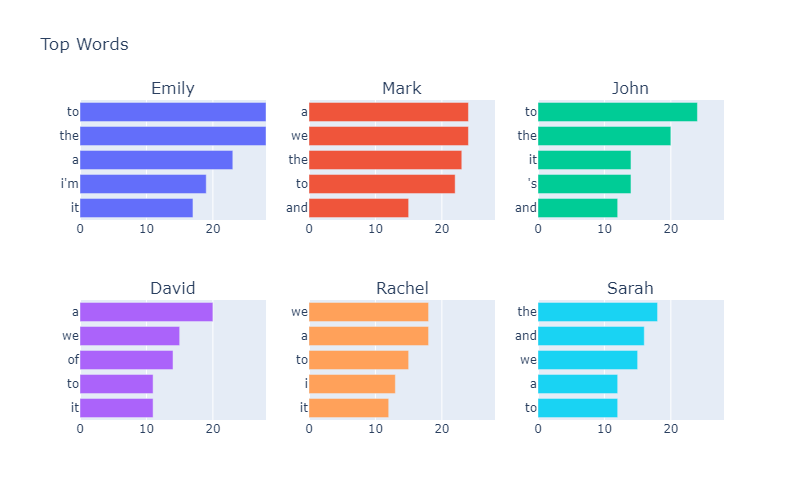

In [36]:
def create_word_frequency_figure(df, n_words, n_people):
    
    data = get_top_words_by_sender(df, n_words, n_people)
    
    def get_subplots_layout(len_data):
        if len_data == 1:
            num_rows = 1
            num_cols = 1
        elif len_data == 2:
            num_rows = 1
            num_cols = 2
        elif len_data == 4:
            num_rows = 2
            num_cols = 2
        else:
            num_rows = (len_data + 2) // 3
            num_cols = 3
        return num_rows, num_cols
    
    num_rows, num_cols = get_subplots_layout(len(data))

    fig_height = 250 * num_rows
    fig = make_subplots(rows=num_rows, cols=num_cols,
                        subplot_titles=list(data.keys()))

    max_count = max([max(data[person].values()) for person in data])

    for i, person in enumerate(data.keys()):
        row = i // num_cols + 1
        col = i % num_cols + 1

        words = list(data[person].keys())
        counts = list(data[person].values())
        
        # Reverse the order of the lists to sort the bars in descending order of count
        words.reverse()
        counts.reverse()

        fig.add_trace(go.Bar(x=counts, y=words, orientation='h', showlegend=False),
                      row=row, col=col)
        fig.update_xaxes(range=[0, max_count], row=row, col=col)
        fig.update_xaxes(title_text='', row=row, col=col)
        fig.update_yaxes(title_text='', row=row, col=col)

    fig.update_layout(title='Top Words', height=fig_height)

    return fig

fig = create_word_frequency_figure(df, 5, 15)
fig.show()

In [37]:
def create_word_frequency_per_person_figure(df, person, n_words):
    
    df_person = df[df['sender'] == person]
    data = get_top_words_by_sender(df_person, n_words, 1)
    words = list(data[person].keys())
    counts = list(data[person].values())
        
    # Reverse the order of the lists to sort the bars in descending order of count
    words.reverse()
    counts.reverse()

    fig = go.Figure()
    fig.add_trace(go.Bar(x=counts, y=words, orientation='h', showlegend=False))
    fig.update_layout(title=f'Top Words of {person}')

    return fig

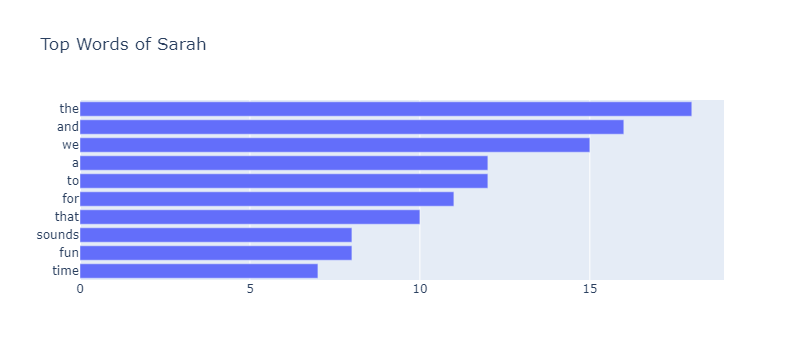

In [38]:
sender = df['sender'].iloc[-1]
fig = create_word_frequency_per_person_figure(df, sender, 10)
fig.show()

### Plot 8

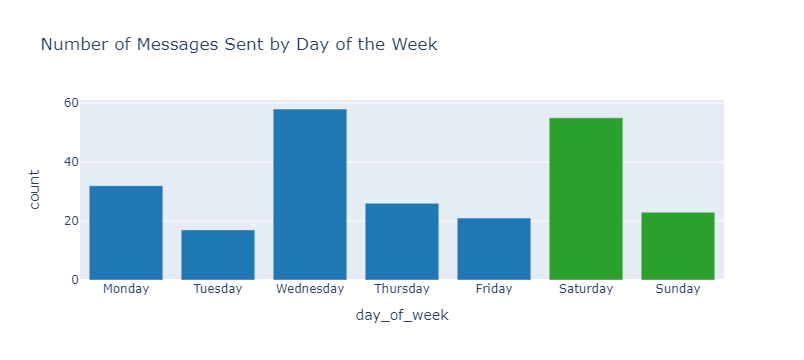

In [39]:
def plot_message_count_by_day_of_week(df):
    # group the DataFrame by day of the week and count the number of messages on each day
    count_by_day = df.groupby('day_of_week').size().reset_index(name='count')

    # create a bar plot of the number of messages by day of the week
    fig = px.bar(count_by_day, x='day_of_week', y='count', 
                 title='Number of Messages Sent by Day of the Week')

    # set the x-axis tick labels to the names of the days of the week
    fig.update_layout(xaxis=dict(
        tickmode='array',
        tickvals=[0, 1, 2, 3, 4, 5, 6],
        ticktext=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    ))

    # set the colors for the weekdays and weekends
    fig.update_traces(marker=dict(color=['#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#2ca02c', '#2ca02c']))

    return fig

fig = plot_message_count_by_day_of_week(df)
fig.show()

### Plot 9

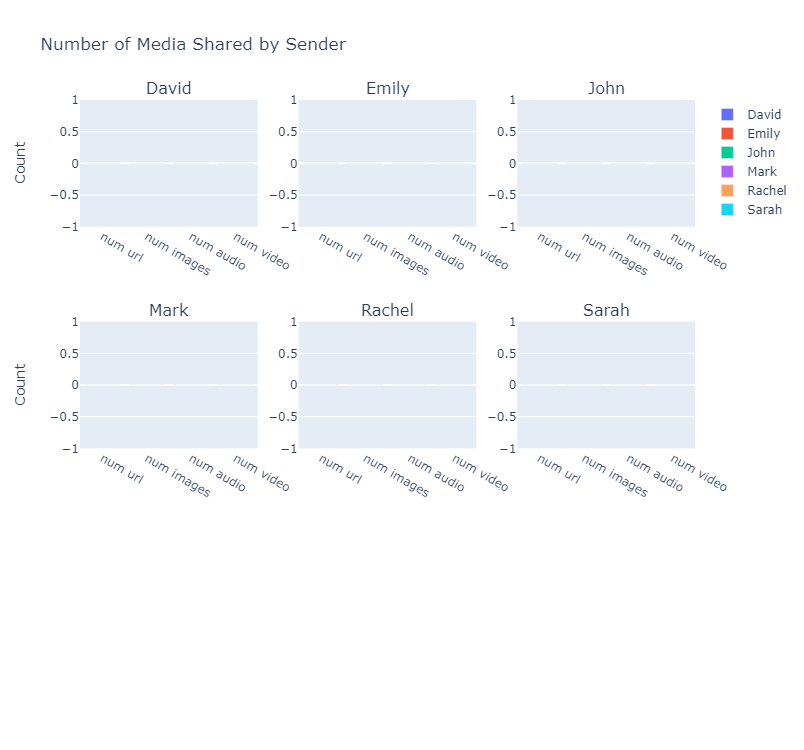

In [40]:
def plot_sender_media_stats(df, num_people):
    # Load the dataframe
    df_sub = df[['sender', 'n_urls', 'is_image', 'is_audio', 'is_video']]

    # Group the dataframe by 'sender' and sum the relevant columns
    df_grouped = df_sub.groupby('sender').sum()

    # Calculate the row sums of the grouped dataframe and sort by them
    df_grouped = df_grouped.loc[df_grouped.sum(axis=1).sort_values(ascending=False).index]

    # Select the first `num_people` unique senders
    senders = df_grouped.index[:num_people]

    # Define the xtick labels
    xtick_names = ['num url', 'num images', 'num audio', 'num video']

    # Create a subplot of bar plots for each sender
    def get_subplots_layout(num_people):
        if num_people == 1:
            num_rows = 1
            num_cols = 1
        elif num_people == 2:
            num_rows = 1
            num_cols = 2
        elif num_people == 4:
            num_rows = 2
            num_cols = 2
        else:
            num_rows = (num_people + 2) // 3
            num_cols = 3
        return num_rows, num_cols

    num_rows, num_cols = get_subplots_layout(num_people)

    fig = sp.make_subplots(rows=num_rows, cols=num_cols, subplot_titles=senders)

    fig_height = 250 * num_rows

    # Initialize the y-axis range to the maximum value across all senders
    y_max = df_grouped.values.max()

    for i, sender in enumerate(senders):
        # Filter the grouped dataframe by the sender
        df_sender = df_grouped.loc[sender]

        # Create a bar trace for the sender
        trace = go.Bar(x=xtick_names, y=df_sender.values, name=sender)

        # Add the bar trace to the subplot
        fig.add_trace(trace, row=(i // 3) + 1, col=(i % 3) + 1)

        # Update the y-axis label for the first subplot in each row
        if i % 3 == 0:
            fig.update_yaxes(title_text='Count', row=(i // 3) + 1, col=1)

        # Set the y-axis range for each subplot to the maximum value across all senders
        fig.update_yaxes(range=[0, y_max], row=(i // 3) + 1, col=(i % 3) + 1)

    # Update the subplot layout
    fig.update_layout(title="Number of Media Shared by Sender", height=fig_height)

    return fig

fig = plot_sender_media_stats(df, 9)
fig.show()

## Stats

### Group Stats

In [41]:
def create_group_stats_part_1(df):
    # Find the min and max dates in the count_by_datetime DataFrame
    min_date = df['datetime'].min()
    max_date = df['datetime'].max()

    # Calculate the number of days between the min and max dates
    num_days_total = (max_date - min_date).days + 1

    # Number of messages in the group
    num_messages = df.shape[0]

    # Average Numebr of Messages in a Day
    avg_messages_per_day = round(num_messages / num_days_total, 2)

    # Group messages by date and count number of messages in each group
    msg_count = df.groupby(df['datetime'].dt.date).size().reset_index(name='count')

    # Count the number of unique dates with at least one message
    num_days_with_messages = len(msg_count)

    # Percentage of Days with Messages
    percentage = (num_days_with_messages / num_days_total) * 100
    percentage_str = "{:.2f}%".format(round(percentage, 2))

    # Find the row with the highest message count
    most_active_date = msg_count.loc[msg_count['count'].idxmax()]

    # Extract the date and message count
    most_active_date_datetime = most_active_date['datetime']
    most_active_date_count = most_active_date['count']
    
    df_group_stats = {}
    df_group_stats['First Message Date'] = min_date.strftime('%B %e, %Y')
    df_group_stats['Last Message Date'] = max_date.strftime('%B %e, %Y')
    df_group_stats['Num. Days in Group'] = num_days_total
    df_group_stats['Num. Messages in Group'] = num_messages
    df_group_stats['Ave. Num. Messages in Day'] = avg_messages_per_day
    df_group_stats['Num. Days w Messege'] = num_days_with_messages
    df_group_stats['Num. Days w/o Messege'] = num_days_total - num_days_with_messages
    df_group_stats['Percentage of Days w Message'] = percentage_str
    df_group_stats['Max Num. Messages in Day'] = most_active_date_count
    df_group_stats['Most Active Date'] = most_active_date_datetime.strftime('%B %e, %Y')
    
    return df_group_stats

In [42]:
def create_group_stats_part_2(df, df_group_stats):
    # Calculate the average number of words per message (no stopwords)
    avg_words_per_message_without_stopwords = np.mean(df['clean_words'].apply(lambda x: len(x)))

    # Calculate the average number of words per message (using the text without removing stopwords)
    avg_words_per_message = np.mean(df['text'].apply(lambda x: len(x.split())))

    # group messages by day of the week and count number of messages in each group
    # extract the day of the week
    msg_count_perday_of_week = df.groupby('day_of_week').size().reset_index(name='count')
    day_of_week = msg_count_perday_of_week.loc[msg_count_perday_of_week['count'].idxmax()]['day_of_week']
    day_of_week_name = calendar.day_name[day_of_week]

    # Group messages by hour and count number of messages in each group
    # find the row with the highest message count
    # extract the hour and message count
    msg_count_by_hour = df.groupby(df['hour']).size().reset_index(name='count')
    most_active_hour = msg_count_by_hour.loc[msg_count_by_hour['count'].idxmax()]
    hour = most_active_hour['hour']

    if hour >= 12:
        am_pm = "PM"
        hour -= 12
    else:
        am_pm = "AM"

    if hour == 0:
        hour = 12

    hour_str = "{:02d}:00 {}".format(hour, am_pm)

    # group messages by sender and count number of messages in each group
    # find the row with the highest message count
    # extract the sender
    msg_count_per_sender = df.groupby('sender').size().reset_index(name='count')
    most_active_person = msg_count_per_sender.loc[msg_count_per_sender['count'].idxmax()]
    most_active_person_sender = most_active_person['sender']

    # group messages by date and sender and count number of messages in each group
    # group messages by date and count number of unique senders in each group
    # find the row with the highest count of unique senders
    # extract the date
    msg_count = df.groupby(['date', 'sender']).size().reset_index(name='count')
    unique_senders_count = msg_count.groupby('date')['sender'].nunique().reset_index(name='count')
    most_active_day = unique_senders_count.loc[unique_senders_count['count'].idxmax()]
    most_active_day_date = most_active_day['date']
    most_active_day_count = most_active_day['count']
    most_active_day_by_sender_str = f"{most_active_day_date.strftime('%B %e, %Y')} with {most_active_day_count} senders"
    
    df_group_stats['Ave. Num. Words in Messsage'] = avg_words_per_message_without_stopwords.round(2)
    df_group_stats['Most Active Day of Week'] = day_of_week_name
    df_group_stats['Most Active Hour in Day'] = hour_str
    df_group_stats['Most Active Person'] = most_active_person_sender
    df_group_stats['Most Active Day by Sender Num'] = most_active_day_by_sender_str

    return df_group_stats

In [43]:
df_group_stats = create_group_stats_part_1(df)
df_group_stats = create_group_stats_part_2(df, df_group_stats)

# Convert the dictionary to a DataFrame and then to a list of dictionaries
df_temp = pd.DataFrame.from_dict(df_group_stats, orient='index', columns=['Value'])
data = df_temp.reset_index().rename(columns={'index': 'Column'}).to_dict('records')   
group_data = pd.DataFrame(data)
group_data

Column                          Value
0              First Message Date                 March 15, 2023
1               Last Message Date                   May 25, 2023
2              Num. Days in Group                             71
3          Num. Messages in Group                            232
4       Ave. Num. Messages in Day                           3.27
5             Num. Days w Messege                             21
6           Num. Days w/o Messege                             50
7    Percentage of Days w Message                         29.58%
8        Max Num. Messages in Day                             38
9                Most Active Date                 March 22, 2023
10    Ave. Num. Words in Messsage                           14.0
11        Most Active Day of Week                      Wednesday
12        Most Active Hour in Day                       02:00 PM
13             Most Active Person                          Emily
14  Most Active Day by Sender Num  March 15, 2023 with 6 senders

### Per Person Stats

In [44]:
def count_messages_per_sender(df):
    
    # group messages by sender and count number of messages in each group
    msg_count = df.groupby('sender').size().reset_index().rename(columns={0: 'n_messages'})

    return msg_count

In [45]:
def most_active_date_per_sender(df):
    
    # Group messages by sender and date, and count the number of messages in each group
    messages_per_sender_date = df.groupby(['sender', df['datetime'].dt.date]).size()

    # Group the resulting series by sender, and find the maximum count and corresponding date for each sender
    max_messages_per_sender = messages_per_sender_date.groupby('sender').agg(['max', 'idxmax']).reset_index()

    # Rename the idxmax column to date, and extract the date from the tuple
    max_messages_per_sender = max_messages_per_sender.rename(columns={'max':'max_n_messages_day', 
                                                                      'idxmax': 'most_active_date'})
    max_messages_per_sender['most_active_date'] = max_messages_per_sender['most_active_date'].apply(
        lambda x: x[1].strftime('%B %e, %Y'))

    # Return the resulting dataframe
    return max_messages_per_sender

In [46]:
def count_unique_words_per_sender(df):
    
    # Explode the clean_words column to create a new row for each word
    df_exploded = df.explode('clean_words')

    # Count the number of unique words written by each sender
    unique_words_per_sender = df_exploded.groupby('sender')['clean_words']\
    .nunique().reset_index().rename(columns={'clean_words':'n_unique_words'})

    return unique_words_per_sender

In [47]:
def combine_user_messages(df):
    user_messages_per_user = df.groupby('sender')['clean_words'].apply(lambda x: [word for words in x for word in words])
    
    user_messages_all = []
    for user in user_messages_per_user.index:
        user_messages_all += user_messages_per_user[user]
    
    return user_messages_per_user, user_messages_all

In [48]:
def count_words_per_user(df):
    user_messages_per_user, user_messages_all = combine_user_messages(df)
    user_messages_per_user = user_messages_per_user.reset_index()
    n_words = user_messages_per_user['clean_words'].apply(lambda x: len(x))
    n_unique_words = user_messages_per_user['clean_words'].apply(lambda x: len(set(x)))
    result_df = pd.DataFrame({'n_words':n_words, 'n_unique_words':n_unique_words})
    
    return result_df

In [49]:
def most_active_day_of_week_per_person(df):
    # Group messages by sender and day of the week, and count the number of messages in each group
    most_active_day_per_person = df.groupby(['sender', 'day_of_week']).size().reset_index(name='count')

    # Find the most active day of the week for each sender
    most_active_day_per_person = most_active_day_per_person.loc[most_active_day_per_person
                                                                .groupby('sender')['count'].idxmax()]

    # Replace the day of the week number with the day of the week name
    most_active_day_per_person['day_of_week'] = most_active_day_per_person['day_of_week'].apply(lambda x: 
                                                                                                calendar.day_name[x])

    # Reset the index
    most_active_day_per_person = most_active_day_per_person.reset_index(drop=True)

    return most_active_day_per_person

In [50]:
def most_active_hour_per_person(df):
    # Group messages by sender and hour, and count the number of messages in each group
    most_active_hour_per_person = df.groupby(['sender', 'hour']).size().reset_index(name='count')

    # Find the most active hour for each sender
    most_active_hour_per_person = most_active_hour_per_person.loc[most_active_hour_per_person
                                                                  .groupby('sender')['count'].idxmax()]

    # Convert the hour to a datetime object and format as a string
    most_active_hour_per_person['hour'] = pd.to_datetime(most_active_hour_per_person['hour'], 
                                                         format='%H').dt.strftime('%I:%M %p')

    # Remove leading zero if present
    most_active_hour_per_person['hour'] = most_active_hour_per_person['hour'].apply(lambda x: 
                                                                                    x.lstrip('0') 
                                                                                    if x.startswith('0') else x)

    # Reset the index
    most_active_hour_per_person = most_active_hour_per_person.reset_index(drop=True)

    return most_active_hour_per_person

In [51]:
def count_media_per_sender(df):
    # Count the number of image messages sent by each sender
    image_count = df.groupby('sender')['is_image'].sum()

    # Count the number of audio messages sent by each sender
    audio_count = df.groupby('sender')['is_audio'].sum()

    # Count the number of video messages sent by each sender
    video_count = df.groupby('sender')['is_video'].sum()

    # Create a new DataFrame with the counts of media messages sent by each sender
    result = pd.DataFrame({'image_count': image_count, 
                           'audio_count': audio_count, 
                           'video_count': video_count}).reset_index()

    return result

In [52]:
def count_urls_and_emojis_per_sender(df):
    # Count the number of URLs sent by each sender
    urls_per_sender = df.groupby('sender')['n_urls'].sum()

    # Count the number of emojis sent by each sender
    emojis_per_sender = df.groupby('sender')['n_emojis'].sum()

    result = pd.DataFrame({'urls_per_sender':urls_per_sender, 'emojis_per_sender':emojis_per_sender}).reset_index()
    return result

In [53]:
def get_emoji_stats(df):
    
    # Get a list of emojis per sender
    emojis_per_sender = df.groupby('sender')['emojis'].sum()

    # Get the most common emoji per sender, if there are any emojis
    most_common_emoji_per_sender = emojis_per_sender.apply(lambda x: max(set(x), key=x.count) if len(x) > 0 else None)

    # Get the number of unique emojis sent by each sender
    n_unique_emojis_per_sender = emojis_per_sender.apply(lambda x: len(set(x)))

    result = pd.DataFrame({'most_common_emoji':most_common_emoji_per_sender, 
                           'n_unique_emojis':n_unique_emojis_per_sender}).reset_index()
    
    return result

In [54]:
def get_user_stats(df):

    df_stats = pd.DataFrame()

    df_stats[['Person Name', 
              'Num Messages']] = count_messages_per_sender(df)[['sender', 
                                                                      'n_messages']]

    df_stats[['Max Messages in Day',
              'Most Active Date']] = most_active_date_per_sender(df)[['max_n_messages_day',
                                                                     'most_active_date']]

    # df_stats['Num Unique Words Used'] = count_unique_words_per_sender(df)['n_unique_words']   


    df_stats[['Total Words', 'Unique Words']] = count_words_per_user(df)[['n_words', 'n_unique_words']]

    df_stats['Words / Message'] = round(df_stats['Total Words'] / 
                                              df_stats['Num Messages'] , 2)

    df_stats['Unique Words / Message'] = round(df_stats['Unique Words'] / 
                                                     df_stats['Num Messages'] , 2)

    df_stats['Most Active Day of Week'] = most_active_day_of_week_per_person(df)['day_of_week']

    df_stats['Most Active Hour'] = most_active_hour_per_person(df)['hour']


    df_stats[['Images',
              'Audios',
              'Videos']] = count_media_per_sender(df)[['image_count',
                                                             'audio_count',
                                                             'video_count']]

    df_stats[['URLs', 
              'Emojis']] = count_urls_and_emojis_per_sender(df)[['urls_per_sender', 
                                                                        'emojis_per_sender']]

    df_stats[['Common Emoji', 
              'Unique Emoji']] = get_emoji_stats(df)[['most_common_emoji', 
                                                           'n_unique_emojis']]

    return df_stats

In [55]:
df_stats = get_user_stats(df)
df_stats

Person Name  Num Messages  Max Messages in Day Most Active Date  \
0       David            32                    5   March 22, 2023   
1       Emily            47                   14   March 22, 2023   
2        John            40                    6   March 25, 2023   
3        Mark            37                    6   March 25, 2023   
4      Rachel            38                    5   March 22, 2023   
5       Sarah            38                    6   March 25, 2023   

   Total Words  Unique Words  Words / Message  Unique Words / Message  \
0          449           190            14.03                    5.94   
1          666           245            14.17                    5.21   
2          541           238            13.52                    5.95   
3          576           227            15.57                    6.14   
4          539           233            14.18                    6.13   
5          477           195            12.55                    5.13   

  Most Active Day of Week Most Active Hour  Images  Audios  Videos  URLs  \
0               Wednesday          2:00 PM       0       0       0     0   
1               Wednesday          2:00 PM       0       0       0     0   
2                Saturday         10:00 AM       0       0       0     0   
3                Saturday         10:00 AM       0       0       0     0   
4               Wednesday          2:00 PM       0       0       0     0   
5                Saturday          2:00 PM       0       0       0     0   

   Emojis Common Emoji  Unique Emoji  
0       0         None             0  
1       0         None             0  
2       0         None             0  
3       0         None             0  
4       0         None             0  
5       0         None             0

In [56]:
df_stats = get_user_stats(df)

# Split the original dataframe into two halves
df_stats_1 = df_stats[['Person Name', 'Num Messages', 'Max Messages in Day', 
                       'Most Active Date', 'Total Words', 'Unique Words']]
df_stats_2 = df_stats[['Person Name', 'Words / Message', 'Unique Words / Message', 
                       'Most Active Day of Week', 'Most Active Hour']]
df_stats_3 = df_stats[['Person Name', 'Images', 'Audios', 'Videos', 
                       'URLs', 'Emojis', 'Common Emoji', 'Unique Emoji']]

# create a Styler object from the DataFrame
styled_df = df_stats_1.style


styled_df = styled_df.set_table_styles([{
    'selector': 'th',
    'props': [('font-weight', 'bold')]
}])

styled_df

## Additional functions

In [57]:
def count_messages_by_user(df):
    # extract the sender names from the 'sender' column and count their occurrences
    sender_counts = df['sender'].value_counts()

    # create a new DataFrame from the sender counts, with columns 'sender' and 'count'
    result_df = pd.DataFrame({'sender': sender_counts.index, 'count': sender_counts.values})

    # sort the DataFrame by 'count' in descending order
    result_df = result_df.sort_values(by='count', ascending=False)

    return result_df

In [58]:
def combine_user_messages(df):
    user_messages_per_user = df.groupby('sender')['clean_words'].apply(lambda x: [word for words in x for word in words])
    
    user_messages_all = []
    for user in user_messages_per_user.index:
        user_messages_all += user_messages_per_user[user]
    
    return user_messages_per_user, user_messages_all

In [59]:
def create_daily_count_df(df):
    # group the messages by day and sender and count the number of messages
    daily_count_df = df.groupby([pd.Grouper(key='datetime', freq='D'), 'sender']).size().unstack(fill_value=0)

    # reset the index and return the new DataFrame
    daily_count_df = daily_count_df.reset_index().rename(columns={'datetime': 'date'})
    
    return daily_count_df

## Future Work

In [60]:
df = extract_data_from_file_path_all_lines('sample_chat.txt')
df = clean_omitted_text(df)
df = extract_replace_urls(df)
df = extract_and_replace_emojis(df)
df = add_datetime_column(df)
df = add_date_columns(df)
df = clean_and_count_words(df, clean_punct_stop_space, nlp_tr)

In [61]:
# Plot the exact time vs the day plot for a specific month.
# Find the times between each message and calculate the average and mean.
# Detect the conversations.
# Find who started the conversation most.
# Visualize the conversations.

In [62]:
# create a new column 'timedelta' which contains the time difference between messages
df['timedelta'] = df['datetime'].diff().dt.total_seconds()

# find the maximum time difference and its index
max_timedelta = df['timedelta'].max()
max_timedelta_index = df['timedelta'].idxmax()

# get the associated dates for the maximum time difference
max_timedelta_date = df.loc[max_timedelta_index, 'datetime']
previous_date = df.loc[max_timedelta_index - 1, 'datetime']

# print the results
print(f"Maximum time difference: {max_timedelta} seconds")
print(f"Associated dates: {previous_date} and {max_timedelta_date}")


Maximum time difference: 1048436.0 seconds
Associated dates: 2023-04-20 11:01:23 and 2023-05-02 14:15:19


In [63]:
# create a new column 'timedelta' which contains the time difference between messages
df['timedelta'] = df['datetime'].diff().dt.total_seconds()

# calculate the mean and median time differences
mean_timedelta = df['timedelta'].mean()
median_timedelta = df['timedelta'].median()

# print the results
print(f"Mean time difference: {mean_timedelta} seconds")
print(f"Median time difference: {median_timedelta} seconds")


Mean time difference: 22687.463203463205 seconds
Median time difference: 14.0 seconds


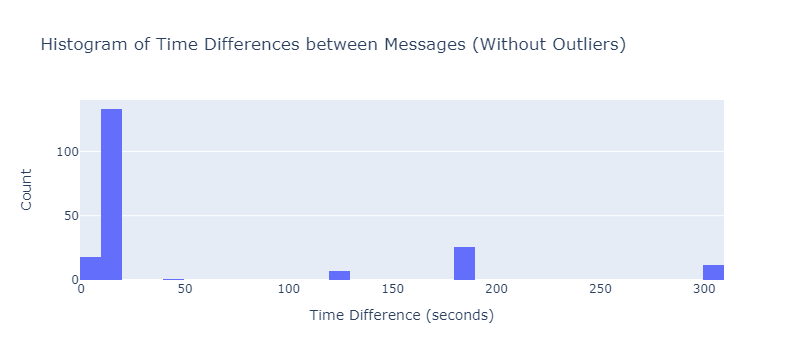

In [64]:
# sort the DataFrame by the 'datetime' column in ascending order
df = df.sort_values(by='datetime')

# create a new column 'timedelta' which contains the time difference between messages
df['timedelta'] = df['datetime'].diff().dt.total_seconds()

# calculate the 25th and 75th percentile of the time differences
q1 = df['timedelta'].quantile(0.25)
q3 = df['timedelta'].quantile(0.75)

# calculate the interquartile range (IQR)
iqr = q3 - q1

# remove the outliers from the 'timedelta' column
df_filtered = df[(df['timedelta'] >= q1 - 1.5 * iqr) & (df['timedelta'] <= q3 + 1.5 * iqr)]

# plot a histogram of the time differences with 50 bins
fig = go.Figure(data=[go.Histogram(x=df_filtered['timedelta'], nbinsx=50)])
fig.update_layout(title='Histogram of Time Differences between Messages (Without Outliers)', xaxis_title='Time Difference (seconds)', yaxis_title='Count')
fig.show()


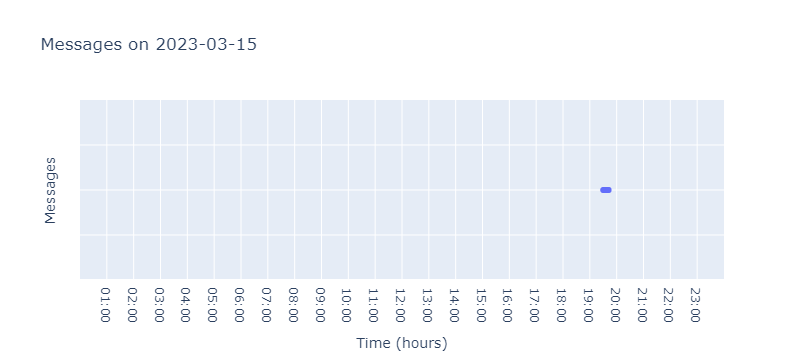

In [65]:
# choose a specific date to plot
# plot_date = pd.Timestamp(2023, 2, 23).date()
plot_date = df['datetime'].iloc[1].date()

# filter the DataFrame to only include messages from the chosen date
df_plot = df[df['datetime'].dt.date == plot_date]

# create a scatter plot of the messages
fig = go.Figure(data=[go.Scatter(x=df_plot['datetime'], y=[1]*len(df_plot), mode='markers')])
fig.update_layout(title=f'Messages on {plot_date}', xaxis_title='Time (hours)', yaxis_title='Messages', yaxis=dict(showticklabels=False), xaxis_range=[plot_date, plot_date + pd.Timedelta(days=1)], xaxis_tickformat='%H:%M')
fig.update_xaxes(tickvals=pd.date_range(plot_date, plot_date + pd.Timedelta(days=1), freq='H'))
fig.show()